In [21]:
import random
import networkx as nx
from matplotlib import pyplot as plt, animation
import numpy as np
import itertools
import pandas as pd

In [22]:
def generate_random_city_graph(connection_prob=0.1, min_weight=1, max_weight=100):
    """
    Generate a random graph representing cities connected with weighted edges.

    Parameters:
    - num_cities (int): Number of cities (nodes) in the graph.
    - connection_prob (float): Probability of a connection (edge) between any two cities.
    - min_weight (int): Minimum weight (distance) for the edges.
    - max_weight (int): Maximum weight (distance) for the edges.

    Returns:
    - G (networkx.Graph): A NetworkX graph with cities as nodes and weighted edges.
    """
    num_cities = random.randint(5,10) # Generate just from 20 to 26 because I want only alphabet characters as nodes
    # Generate random city names (A, B, C, ...)
    city_names = [chr(65 + i) for i in range(num_cities)]

    # Create a graph
    G = nx.Graph()

    # Add cities as nodes
    G.add_nodes_from(city_names)

    # Randomly connect cities with random weights (distances)
    for i in range(num_cities):
        for j in range(i + 1, num_cities):
            weight = random.randint(min_weight, max_weight)  # Random distance
            G.add_edge(city_names[i], city_names[j], weight=weight)

    return G

In [23]:
# Example usage
random_graph = generate_random_city_graph()

In [24]:
def draw_graph(G):
    """
    Draw the generated graph with cities and weighted connections.

    Parameters:
    - G (networkx.Graph): The graph to be drawn.
    """
    pos = nx.spring_layout(G)
    edges = G.edges(data=True)

    # Clear any previous plot
    plt.clf()
    
    # Draw the graph
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')
    #nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges})
    #nx.draw_networkx_edge(G, pos, with_labels=False)

    plt.title("Graph")
    plt.show()
    return pos

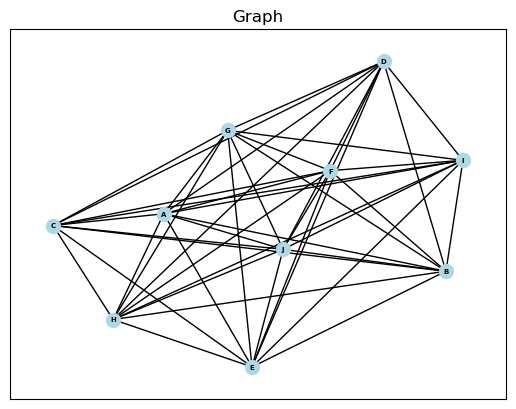

In [25]:
originalLayout = draw_graph(random_graph)

In [26]:
list(random_graph.nodes)[0]

'A'

In [27]:
len(random_graph)

10

In [28]:
class Solution:
    def __init__(self, dimension, lower_bound, upper_bound):
        self.d = dimension
        self.lower = lower_bound # we will use the same bounds for all parameters
        self.upper = upper_bound
        self.params = np.zeros(self.d) #solution parameters
        self.f = np.inf # objective function evaluation

In [100]:
class Ant():
    def __init__(self, startPosition):
        self.path = []
        self.startPosition = startPosition
        self.position = startPosition
        self.path.append(startPosition)
        self.travelledDistance = 0
        self.visibilityMatrix = None
    
    def initialize(self, startPosition): # Put ant into default setting
        self.startPosition = startPosition
        self.path = []
        self.path.append(startPosition)
        self.travelledDistance = 0
        self.position = startPosition

    def goToNextSpot(self, spotIndex):
        self.path.append(spotIndex)
        self.position = spotIndex

    def finished(self):
        self.path.append(self.startPosition)
        self.travelledDistance = 0
        for i in range(1, len(self.path)):
            self.travelledDistance += self.visibilityMatrix[self.path[i-1]][self.path[i]] # From -> To 
        print(f"Total distance: {self.travelledDistance}, path: {self.path}")

    def getCurrentPosition(self):
        return self.position
    
    def spreadPheromones(self, pheromones): # Sum part of formula influenced by ant's distance travelled 
        for i in range(1, len(self.path)):
            pheromones[self.path[i-1]][self.path[i]] += 1/self.travelledDistance
        return pheromones    

# Takes count of ants and position where they are going to start
def spawnAnts(n, startPosition, distanceMatrix) -> list[Ant]:
    antPopulation = []
    for i in range(0, n):
        antPopulation.append(Ant(startPosition=startPosition))
        antPopulation[i].visibilityMatrix = initVisibilityMatrix(distanceMatrix=distanceMatrix)
    return antPopulation

# Pass count of nodes, inits pheromone matrix full of 1's
def initPheromone(n):
    matrix = []
    for i in range(0,n):
        matrix.append([])
        for j in range(0,n):
            matrix[i].append(1)
    return matrix

# Pass distance matrix, returns visibility matrix based on 1/d[i][j] formula
def initVisibilityMatrix(distanceMatrix):
    matrix = []
    n = len(distanceMatrix)
    for i in range(0,n):
        matrix.append([])
        for j in range(0,n):
            if i != j:
                visibility = 1/distanceMatrix[i][j]
                matrix[i].append(visibility)
            else:
                matrix[i].append(0)
    return matrix

# Pass visibility matrix and index of column you want to null
def nullColumn(visibilityMatrix, j):
    n = len(visibilityMatrix)
    #print(j)
    for i in range(0, n):
        visibilityMatrix[i][j] = 0
    return visibilityMatrix

def decideNextPath(visibilityMatrix, pheromones, currentPosition, alpha = 1, beta = 2):
    probabilites = []
    n = len(visibilityMatrix)
    for j in range(0, n):
        if currentPosition != j and visibilityMatrix[currentPosition][j] != 0:
            probability = pow(pheromones[currentPosition][j], alpha) * pow(visibilityMatrix[currentPosition][j], beta) # TODO: Finish this formula
            probabilites.append((j, probability))
    #print(probabilites)
    if len(probabilites) == 1: # If there is only one spot to go to left
        return probabilites[0][0]
    probSum = 0
    for index, value in probabilites: # get total sum of probabilities
        probSum += value
    for i in range(len(probabilites)): # Calculate probability formula
        probabilites[i] = (probabilites[i][0], probabilites[i][1]/probSum)
    r = random.uniform(0,1)
    for i in range(1, len(probabilites)): # Cumulate probabilites
        probabilites[i] = (probabilites[i][0], probabilites[i][1] + probabilites[i-1][1])
    for i in range(len(probabilites) - 1):
        if r < probabilites[i][1]:
            #print(f"R lower Random number: {r}, probabilities: {probabilites}, result: {probabilites[i][0]} current position: {currentPosition}")
            return probabilites[i][0]
        if r >= probabilites[i][1] and r <= probabilites[i + 1][1]:
            #print(f"R in gap Random number: {r}, probabilities: {probabilites}, result: {probabilites[i + 1][0]} current position: {currentPosition}")
            return probabilites[i + 1][0]


#Main algorithm
def AntColony(G):
    distanceMatrix = nx.adjacency_matrix(G).toarray() # Get distance matrix
    startPosition = 0 # Start from random? position, this position stays the same for entirety of algorithm
    antCount = 10
    ants = spawnAnts(antCount, startPosition, distanceMatrix.copy())
    pheromones = initPheromone(len(G)) # Init pheromone matrix
    p = 0.5
    alpha = 1
    beta = 2
    max_iters = 200 # 1 For now, later 100
    bestPathRecord = []
    bestDistance = 40000 # inf
    for _ in range(0,max_iters):
        for ant in ants:
            rStartPosition = random.randint(0, len(G) - 1)
            ant.initialize(rStartPosition) # Set ant to fresh default state
            # Here do logic for ants pathing
            visibilityMatrix = initVisibilityMatrix(distanceMatrix=distanceMatrix) # Each ant has its own visibility matrix
            visibilityMatrix = nullColumn(visibilityMatrix, rStartPosition) # Null start position
            for i in range(len(G) - 1): # - 2 because we cant go to startPosition and we dont want to loop again after going to last spot
                nextSpot = decideNextPath(visibilityMatrix, pheromones, ant.getCurrentPosition())
                ant.goToNextSpot(nextSpot)
                visibilityMatrix = nullColumn(visibilityMatrix, ant.getCurrentPosition()) # Null start position
            print(visibilityMatrix)
            ant.finished()
            if ant.travelledDistance < bestDistance:
                bestPathRecord.append((ant.path, ant.travelledDistance))
                bestDistance = ant.travelledDistance
        pheromones = list((1-p)*np.array(pheromones)) # First half of pheromones formula thats based on previous pheromones values
        for ant in ants: # Second half thats based on individual ants travelled distances
            pheromones = ant.spreadPheromones(pheromones)
    return bestPathRecord
    


In [101]:
bestPathRecord = AntColony(random_graph)
for record in bestPathRecord:
    print(record)

C:\Users\Michal\AppData\Local\Temp\ipykernel_10196\160995145.py:104: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  distanceMatrix = nx.adjacency_matrix(G).toarray() # Get distance matrix


[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Total distance: 2.3601884689273804, path: [1, 7, 4, 8, 2, 3, 0, 5, 9, 6, 1]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Total distance: 2.1503613095342415, path: [7, 1, 2, 8, 9, 6, 3, 0, 4, 5, 7]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 

In [102]:
len(random_graph)

10

In [108]:
def mapPath(G, path):
        nodes = []
        for index in path:
            nodes.append(list(G.nodes)[index])
        return nodes

def constructPathGraph(G, path):

    subG = nx.Graph()
    path = mapPath(G, path)
    subG.add_nodes_from(path)
    for i in range(0,len(path) - 1):
        fromIndex = path[i]
        toIndex = path[i+1]
        weight = G[fromIndex][toIndex]["weight"]
        subG.add_edge(path[i], path[i+1], weight=weight)
    return subG

In [104]:
subG = constructPathGraph(random_graph, bestPathRecord[0][0])
subG.edges

EdgeView([('B', 'H'), ('B', 'G'), ('H', 'E'), ('E', 'I'), ('I', 'C'), ('C', 'D'), ('D', 'A'), ('A', 'F'), ('F', 'J'), ('J', 'G')])

In [ ]:
paths = [path for path, distance in bestPathRecord]
paths

[['B', 'H', 'E', 'I', 'C', 'D', 'A', 'F', 'J', 'G', 'B'],
 ['H', 'B', 'C', 'I', 'J', 'G', 'D', 'A', 'E', 'F', 'H'],
 ['D', 'A', 'I', 'C', 'B', 'H', 'J', 'G', 'E', 'F', 'D'],
 ['D', 'A', 'B', 'H', 'I', 'C', 'E', 'F', 'J', 'G', 'D'],
 ['J', 'I', 'C', 'D', 'H', 'B', 'E', 'G', 'F', 'A', 'J'],
 ['H', 'B', 'C', 'D', 'A', 'I', 'J', 'G', 'E', 'F', 'H'],
 ['G', 'C', 'D', 'A', 'I', 'J', 'F', 'E', 'B', 'H', 'G'],
 ['B', 'H', 'D', 'A', 'I', 'E', 'G', 'J', 'F', 'C', 'B'],
 ['C', 'D', 'H', 'B', 'A', 'G', 'E', 'I', 'J', 'F', 'C']]

In [110]:
def animateTSM(G, paths, pos):
    plt.rcParams["figure.figsize"] = [7.50, 3.50]
    plt.rcParams["figure.autolayout"] = True

    fig = plt.figure(figsize=(10, 6))
    path = nx.Graph()
    path.add_nodes_from(G.nodes)
    nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')

    def animate(i):
        fig.clear()
        fig.suptitle("Index: " + str(i))
        constructedPath = constructPathGraph(G, paths[i])
        path.add_edges_from(list(constructedPath.edges))
        nx.draw_networkx(path, with_labels=True, pos = pos, node_color='lightblue', node_size=100, font_size=5, font_weight='bold')
        path.remove_edges_from(list(constructedPath.edges))
        
    ani = animation.FuncAnimation(fig, animate, frames=len(paths), interval=1000, repeat=True)
    ani.save("TSMAnimation.gif")
    plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


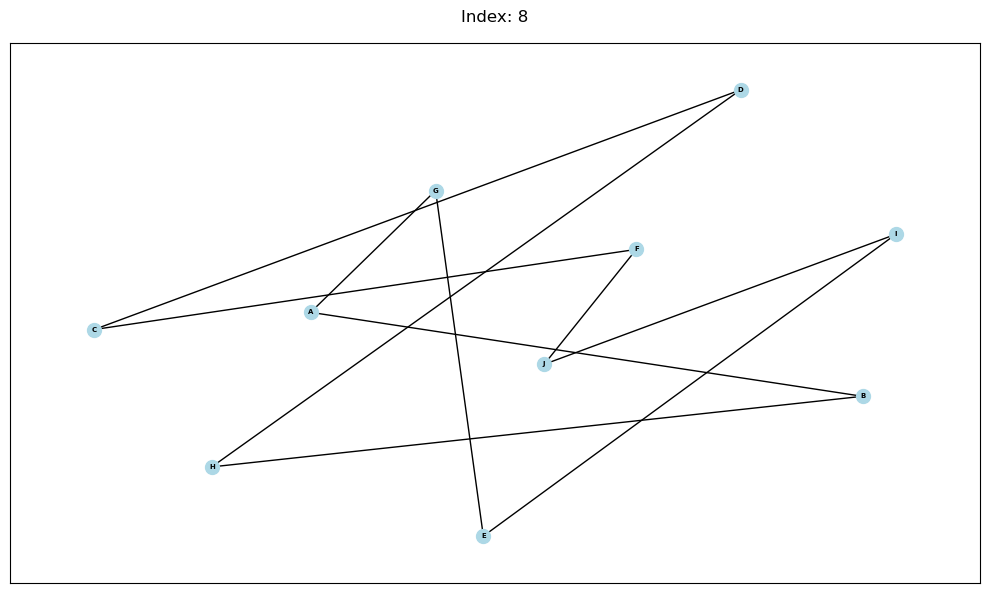

In [113]:
animateTSM(random_graph, np.array(paths), originalLayout)